# Inference on Winners
Julian Hsu
21-Oct-2023


The purpose of this script is to show an example of Winners Curse as demonstrated in ["Inference on Winners," NBER Paper](https://www.nber.org/papers/w25456). We are going to just show the problem, and refer the reader to the paper about the solution.




**Sound byte:**
You set up your experiment perfectly and found a treatment-control different of 5%. "Based on these results, we expect rolling out the treatment nation-wide will be 5%." That statement is incorrect. When looking at experiments where the **treatment is larger than control** , we are more likely to over-estimate the true impact.

Using simulated data below (here), I show that the smaller the true impact is, the more likely your experiment over-estimates the true impact. 

To be clear, you've made the correct decision and decided to roll out the treatment. However, noise plays an asymmetric role in predicting the impact of the roll out. You've correctly accounting for noise causing you to make the wrong decision, but you also need to account for noise influencing your estimate.


Are you interested in a solution? Want to learn more? Then check out "Inference on Winners" (paper: https://scholar.harvard.edu/files/iandrews/files/inference_on_winners.pdf \ video: https://www.youtube.com/watch?v=Zs6FqGvRIuQ&t=404s&pp=ygUUaW5mZXJlbmNlIG9uIHdpbm5lcnM%3D) which inspired this post.

___

**Alternative sound byte:**
Your decision to launch and rollout the winning treatment will over-estimate its actual impact. When looking at experiments where the **treatment was larger than control**, we are more likely to over estimate the true impact. The smaller the true effect size is, the greater the bias is. The root cause is that since you are only looking at instances when the treated is *estimated* to be greater than control, noise plays an asymmetric role because it is more likely to get you to launch your treatment. 

Next time you are experimenting with incremental improvements to your product, keep in mind that the actual impact of rolling our your treatment is more likely to be smaller than the impact you get from your experiment. 

Are you interested in a solution? Want to learn more? Then check out "Inference on Winners" (paper: https://scholar.harvard.edu/files/iandrews/files/inference_on_winners.pdf \ video: https://www.youtube.com/watch?v=Zs6FqGvRIuQ&t=404s&pp=ygUUaW5mZXJlbmNlIG9uIHdpbm5lcnM%3D) which inspired this post.

Check out the simulation notebook here (link), where I show that this is different from statistical power based on simulated evidence.


**Setup in words:** Suppose we have a randomized treatment between different treatment groups.   We have a *policy* that picks the treatment (or control) with the largest estimate. This policy will:
1. Over estimate the actual impact; and 
2. Does not accurately represent the confidence interval about its effectiveness.

We can see this by focusing on a few statistics:
1. Positive Median Bias - the probability the estimated treatment is greater than the true treatment, conditional on following the policy, is greater than 0.5; and 
2. Coverage probability - that the probability the confidence interval covers the true impact is less than 1- $\alpha$

In [106]:
import numpy as np
import pandas as pd

from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import TTestIndPower

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


0.9986074105881142

## DGP and Setup
We want to calculcate confidence intervals and point estimates, conditional on one treatment being the best one.

In [117]:
def decide_treatment(te = [3], N=1000):
    ## How many treatments are there
    tn  = len(te)    
    ## Assume arms are equally sized
    n = int(N / (tn +1) )
    
    ## Collect average outcomes
    outcome_avg = []
    result_df = pd.DataFrame()
    ## Control arm
    x = np.random.normal(0,1, n )    
    outcome_avg.append(np.average(x))
    ## Treatment arm
    ## Calculate the differences and confidence intervals
    ## between each treatment and control
    for t in range(tn):
        x1 = np.random.normal(0,1,n)+te[t]
        
        diff = np.average(x1) - np.average(x)
                
        tstat,pvalue,df = ttest_ind(x,x1, alternative='two-sided')
        se = np.abs(diff/tstat)
        
        result_row = pd.DataFrame(
            index=[t]
            ,data={'treatment':t
            ,'se':se
            ,'pvalue':pvalue
             ,'ci95_lower':diff-1.96*se
             ,'ci95_upper':diff+1.96*se
            ,'diff':diff
            ,'true_diff':te[t]})
        result_df = pd.concat([result_df, result_row])
        outcome_avg.append(np.average(x1))
    
    ## Pick the largest treatment
    winner = np.argmax(outcome_avg)
    result_df['winner']=winner
    return result_df
    

In [118]:
sim_number = 200

In [129]:
df = pd.DataFrame()
df['power']=0
for s in range(sim_number):
    for t in [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.05, 0.07, 0.08, 0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.75]:
        df = pd.concat([df, decide_treatment(te = [t], N=100)])
        df['power'].fillna( TTestIndPower().solve_power(effect_size = t
                         ,nobs1=50
                         ,alpha=0.05
                         ,power=None
                         ,ratio=1),inplace=True )
    

In [130]:
'''
 Calculate the probability the estimated treatment is greater than the true estimate.
 
 Calculate the probability the 95% confidence interval contains the true effect
'''
df['estimated_greater_than_true'] = df['diff'] > df['true_diff']
df['contains_true_effect'] = df['true_diff'].between(df['ci95_lower'], df['ci95_upper'])
df['stat_sig'] = df['pvalue'] < 0.05

df_plot = df.groupby(['true_diff','winner']).agg(
estimated_greater_than_true=('estimated_greater_than_true','mean')
, contains_true_effect=('contains_true_effect','mean')    
, estimated_diff=('diff','mean')
, N = ('estimated_greater_than_true','count')
, power=('power','mean'))

df_plot_stat_sig =  df.loc[df['stat_sig']==1].groupby(['true_diff','winner']).agg(
estimated_greater_than_true=('estimated_greater_than_true','mean')
, contains_true_effect=('contains_true_effect','mean')    
, estimated_diff=('diff','mean')
, N = ('estimated_greater_than_true','count')
, power=('power','mean'))

In [131]:
df_plot.reset_index(inplace=True)
df_plot_stat_sig.reset_index(inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


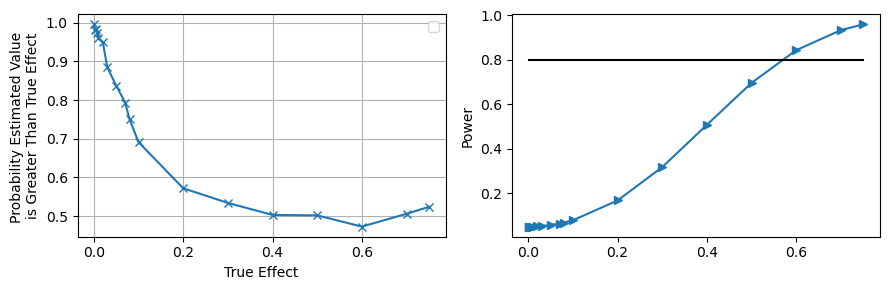

In [136]:
'''
Plot these
'''

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
df_plot_w = df_plot.loc[df_plot['winner']==1]
df_plot_stat_sig_w = df_plot_stat_sig.loc[df_plot['winner']==1]
ax[0].plot(df_plot_w['true_diff'], df_plot_w['estimated_greater_than_true'], marker='x')
# ax[0].plot(df_plot_stat_sig_w['true_diff'], df_plot_stat_sig_w['estimated_greater_than_true'], marker='o', color='seagreen')
ax[0].set_ylabel('Probability Estimated Value \nis Greater Than True Effect')
ax[0].set_xlabel('True Effect')
ax[0].grid()
ax[0].legend()

# ax[1].plot(df_plot_w['true_diff'], df_plot_w['contains_true_effect'], marker='>')
# ax[1].plot(df_plot_w['true_diff'], [0.95]*len(df_plot_w), color='black')
# ax[1].set_ylabel('Probability Winner Treatment\n contains True Effect')

ax[1].plot(df_plot_w['true_diff'], df_plot_w['power'], marker='>')
ax[1].plot(df_plot_w['true_diff'], [0.80]*len(df_plot_w), color='black')
ax[1].set_ylabel('Power')


fig.tight_layout()